In [1]:
from tifffile import imread
import numpy as np
import h5py
import math
import io
import hdf5plugin as h5pl
import matplotlib.pyplot as plt
import io

In [2]:
def convert_img_dtype(img, dtype=np.uint16):
    """Convert and normalize each slice of the image to the specified unsigned integer dtype."""
    if img.dtype == dtype:
        return img
    else:
        img = img.astype(float)
        
        # Normalize each slice independently
        img_max = np.amax(img, axis=(1, 2), keepdims=True)
        img_max[img_max == 0] = 1  # Prevent division by zero
        img /= img_max
        
        # Convert to the specified dtype
        if dtype == np.uint8:
            img = np.array(img * (2**8 - 1), dtype=np.uint8)
        elif dtype == np.uint16:
            img = np.array(img * (2**16 - 1), dtype=np.uint16)
        elif dtype == np.uint32:
            img = np.array(img * (2**32 - 1), dtype=np.uint32)
        else:
            raise ValueError(f"{dtype} not supported yet!")
        
        return img

In [3]:
def get_image_nbytes(shape, dtype):
    plain_size = np.prod(shape)
    
    if dtype == np.uint8:
        factor = 1
    elif dtype == np.uint16:
        factor = 2
    elif dtype == np.uint32:
        factor = 4
    else:
        raise ValueError(f"{dtype} not supported yet!")
    
    return plain_size * factor

In [4]:
def determine_dtype(target_bit):
    if target_bit <= 8:
        dtype = np.uint8
    elif target_bit <= 10:
        dtype = np.uint16
    else:
        raise ValueError(f'{target_bit} bit not supported yet!')
    return dtype


In [5]:
def beta_quantization(img, target_bit=10):
    # determine the dtype
    dtype = determine_dtype(target_bit)
    
    img = img.astype(float)
    # casting
    if dtype == np.uint8: # 8bit
        beta = math.log(np.amax(img), 2**8-1)
        img = np.power(img, 1./beta)
        img = np.clip(img, 0, 255)
        img = np.array(img, dtype=np.uint8)
    elif dtype == np.uint16: # 10bit
        beta = math.log(np.amax(img), 2**10-1)
        img = np.power(img, 1./beta)
        # img = np.clip(img, 0, 1023)
        img = np.array(img, dtype=np.uint16)
    else:
        raise ValueError(f"{dtype} not supported yet!")
        
    return beta, img

In [6]:
def beta_dequantization(img, beta, org_dtype):
    if org_dtype == np.uint8:
        max_val = 2**8 - 1
    elif org_dtype == np.uint16:
        max_val = 2**16 - 1
    elif org_dtype == np.uint32:
        max_val = 2**32 - 1
    else:
        raise ValueError(f"{org_dtype} not supported yet!")
    
    img = img.astype(float)
    img = np.power(img, beta)
    img = np.clip(img, 0, max_val)
    img = np.array(img, dtype=org_dtype)

    return img

uint16


(-0.5, 255.5, 255.5, -0.5)

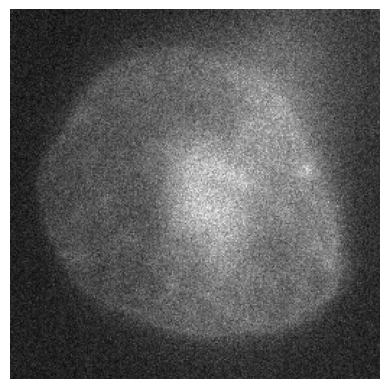

In [7]:
img = imread('../example_data/DRAQ5.tif')
print(img.dtype)
plt.imshow(img[0, ...], cmap='gray')
plt.axis('off')

uint8


(-0.5, 255.5, 255.5, -0.5)

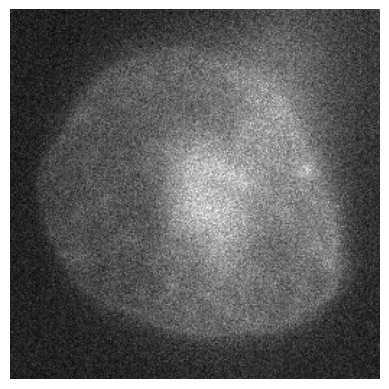

In [8]:
img = convert_img_dtype(img, dtype=np.uint8)
print(img.dtype)
original_dtype = img.dtype
plt.imshow(img[0, ...], cmap='gray')
plt.axis('off')

In [9]:
# params = (2, 1, 256, 256, 256, 0, 10, 10, 10, 0, 0)  # X264
# params = (4, 3, 256, 256, 256, 0, 200, 200, 15, 0, 0) # X265
params = (6, 6, 256, 256, 256, 0, 400, 400, 20, 0, 0) # SVT-AV1

In [10]:
beta, quantized_img = beta_quantization(img, target_bit=8)

In [11]:
with io.BytesIO() as tmpfile:
    with h5py.File(tmpfile, 'w') as h5file:
        h5file.create_dataset('data', data=quantized_img, chunks=quantized_img.shape, **h5pl.FFMPEG(*params))
        print(f'Compression ratio is {get_image_nbytes(img.shape, img.dtype)/tmpfile.getbuffer().nbytes}')
    with h5py.File(tmpfile, 'r') as h5file:
        tmp = np.array(h5file['data'])

# dequantization
tmp = beta_dequantization(tmp, beta, original_dtype)
print(tmp.dtype)

Compression ratio is 3.5063604605839958
uint8


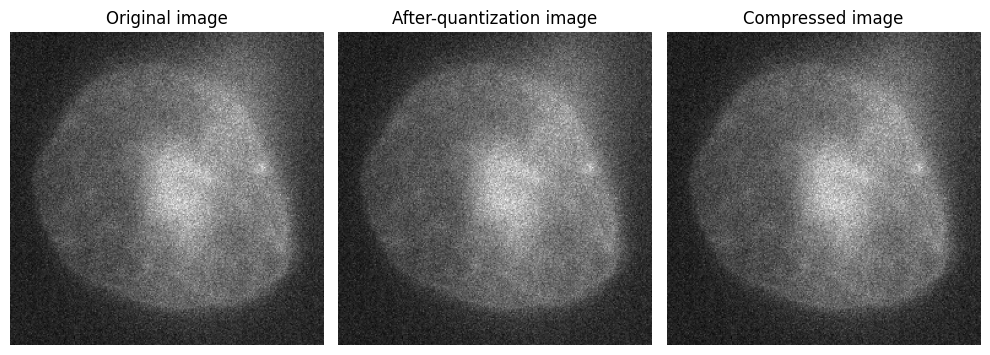

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img[0, ...], cmap='gray')
axes[0].set_title('Original image')
axes[0].axis('off')

axes[1].imshow(quantized_img[0, ...], cmap='gray')
axes[1].set_title('After-quantization image')
axes[1].axis('off')

axes[2].imshow(tmp[0, ...], cmap='gray')
axes[2].set_title('Compressed image')
axes[2].axis('off')

plt.tight_layout()
plt.show()